<a href="https://colab.research.google.com/github/EddyGiusepe/Neural_Network_from_scratch_only_with_Python/blob/main/Neural_Network_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align="center">Rede Neural usando PyTorch</h2>


Data Scientist.: Dr.Eddy Giusepe Chirinos Isidro

Este script foi baseado no tutorial de [Pepe Cantoral, PhD](https://www.youtube.com/watch?v=qQELiV1_GHA&list=PLWzLQn_hxe6ZlC9-YMt3nN0Eo-ZpOJuXd&index=21).


Neste estudo usaremos `PyTorch` com a ideia de aproveitar o este Framework de Deep Learning. Para começar utilizaremos apenas o `Modulo Sequential`.

# PyTorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importamos as nossas bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F

# Importamos as nossas Imagens

In [3]:
# Importar MNIST
# Ver vídeo para aprender a importar estes Dados: https://www.youtube.com/watch?v=7cMKAlnSmpM

import gzip
import os
from os.path import isfile, join
def list_files(mnist_path):
    return [join(mnist_path,f) for f in os.listdir(mnist_path) if isfile(join(mnist_path, f))]

def get_images(mnist_path):
    for f in list_files(mnist_path):
        if 'train-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                train_images = data.read()
                x_train = np.frombuffer(train_images, dtype=np.uint8)
                x_train = x_train.reshape((num_images, rows, cols))
        elif 'train-labels' in f:
            with gzip.open(f, 'rb') as data:
                train_labels = data.read()[8:]
                y_train = np.frombuffer(train_labels, dtype=np.uint8)
        if 't10k-images' in f:
            with gzip.open(f, 'rb') as data:
                _ = int.from_bytes(data.read(4), 'big')
                num_images = int.from_bytes(data.read(4), 'big')
                rows = int.from_bytes(data.read(4), 'big')
                cols = int.from_bytes(data.read(4), 'big')
                test_images = data.read()
                x_test = np.frombuffer(test_images, dtype=np.uint8)
                x_test = x_test.reshape((num_images, rows, cols))
        elif 't10k-labels' in f:
            with gzip.open(f, 'rb') as data:
                test_labels = data.read()[8:]
                y_test = np.frombuffer(test_labels, dtype=np.uint8)
    
    return x_train, y_train, x_test, y_test    

In [4]:
# Aqui passamos o caminho: MNIST path
# Obviamente os Dados já foram baixados com antecedencia

mnist_path = '/content/drive/MyDrive/2_DEEP_LEARNING_REDES_NEURAIS_Jorge/1_Pytorch_Deep_Learning/Pytorch_examples/Rede_neural_exemplo_Pytorch/data/MNIST/raw/mnist_raw'

In [5]:
# Aqui utilizamos a função "get_images()" 
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)


# Aquí dividimos nuestros Datos en train, val y test
# También los convertimos a vectores
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)
y_train = y_train_num[:50000].reshape(50000, 1)

x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float)
y_val = y_train_num[50000:].reshape(10000, 1)

x_test = x_test_num.copy().reshape(10000, -1).astype(np.float)
y_test = y_test_num.copy().reshape(10000, 1)


# Normalizar imagens

In [6]:
# Normalizamos para ter uma média=0 e std=1

def normalise(x_mean, x_std, x_data):
  return (x_data - x_mean) / x_std


In [7]:
x_mean = x_train.mean()
x_std = x_train.std()

print(x_mean, x_std)

33.395157 78.66619


In [8]:
# Aqui teremos nossos Dados Normalizados

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [9]:
# Verificando a média e std para Dados de Treinamento
x_train.mean(), x_train.std()

(-3.1638146e-07, 0.99999934)

In [10]:
# Verificando a média e std para Dados de Validação
x_val.mean(), x_val.std()

(-0.0058509559841872305, 0.9924333474151182)

# Visualizamos algumas das nossas Imagens

In [11]:
x_test.shape

(10000, 784)

In [12]:
y_train.shape

(50000, 1)

In [13]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()
    

A imagem printada representa um: 5


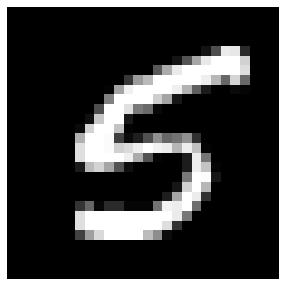

In [14]:
rnd_idx = np.random.randint(len(y_test))
print(f'A imagem printada representa um: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

# Criamos a função de Mini-batches

In [15]:
def create_minibatches(x, y, mb_size, shuffle = True):
    '''
    x  # Amostras, 784
    y  # Amostras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Erro em quantidade de amostras'
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

# Agora sim ... PyTorch

# Converter NumPy array a PyTorch

In [16]:
# Convertendo para Tensores do PyTorch

x_train_tensor = torch.tensor(x_train.copy())
y_train_tensor = torch.tensor(y_train.copy())

x_val_tensor = torch.tensor(x_val.copy())
y_val_tensor = torch.tensor(y_val.copy())

x_test_tensor = torch.tensor(x_test.copy())
y_test_tensor = torch.tensor(y_test.copy())


# Usar GPU de estiver disponível

In [17]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Estammos usando: {device}')

Estammos usando: cpu


# Calculamos Accuracy

In [18]:
def accuracy(model, x, y, mb_size):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in create_minibatches(x, y, mb_size):
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size ) - "dim" é do Pytorch
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1). squeeze() eliminará esse 1.
            num_total += pred.size(0)

            return float(num_correct)/num_total

# Loop de Treinamento

In [19]:
def train(model, optimiser, mb_size, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in create_minibatches(x_train_tensor, y_train_tensor, mb_size):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)
            # funcion cost
            cost = F.cross_entropy(input= scores, target=yi.squeeze())
            optimiser.zero_grad()
            cost.backward()
            optimiser.step()
            
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {accuracy(model, x_val_tensor, y_val_tensor, mb_size)}')

# Modelo usando Sequential

In [20]:
#Instanciar modelo
hidden1 = 1000 # Neurônios
hidden = 1000
lr = 5e-2
epochs = 20 # 100
mb_size = 2048 # 4096

# Criamos nosso Modelo
model1 = nn.Sequential(nn.Linear(in_features=784, out_features=hidden1), # Capa Linear
                       nn.ReLU(), # Capa de função de Ativação
                       nn.Linear(in_features=hidden1, out_features=hidden), # Outra capa Linear
                       nn.ReLU(),
                       nn.Linear(in_features=hidden, out_features=10)) # A nossa saída é 10, porque temos 10 classes


optimiser = torch.optim.SGD(model1.parameters(), lr=lr)

train(model1, optimiser, mb_size, epochs)

Epoch: 0, costo: 1.3201227188110352, accuracy: 0.77685546875
Epoch: 1, costo: 0.6292073130607605, accuracy: 0.87939453125
Epoch: 2, costo: 0.500742495059967, accuracy: 0.88134765625
Epoch: 3, costo: 0.40553298592567444, accuracy: 0.88720703125
Epoch: 4, costo: 0.40270867943763733, accuracy: 0.90576171875
Epoch: 5, costo: 0.35970625281333923, accuracy: 0.9091796875
Epoch: 6, costo: 0.31996676325798035, accuracy: 0.916015625
Epoch: 7, costo: 0.3086887001991272, accuracy: 0.921875
Epoch: 8, costo: 0.30536025762557983, accuracy: 0.91748046875
Epoch: 9, costo: 0.292764276266098, accuracy: 0.92578125
Epoch: 10, costo: 0.2877843677997589, accuracy: 0.9248046875
Epoch: 11, costo: 0.2839469313621521, accuracy: 0.93359375
Epoch: 12, costo: 0.28555312752723694, accuracy: 0.9296875
Epoch: 13, costo: 0.2000976949930191, accuracy: 0.93359375
Epoch: 14, costo: 0.2205757051706314, accuracy: 0.92529296875
Epoch: 15, costo: 0.20942121744155884, accuracy: 0.92041015625
Epoch: 16, costo: 0.257248371839523

In [21]:
accuracy(model1, x_test_tensor,  y_test_tensor, mb_size)

0.947265625